# Exploratory Data Analysis
## SPY Options Data from WRDS OptionMetrics

In [ ]:
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

repo_path = os.getenv("REPO_PATH")
sys.path.append(repo_path+"src")

from data_loader import (
    load_raw_data,
    get_spot_price,
    prepare_option_data,
    split_data
)
from preprocessing import (
    clean_data,
    compute_implied_volatilities,
    normalize_features,
    create_model_dataset,
    add_additional_features
)
from visualize import (
    plot_volatility_smile,
    plot_volatility_surface_3d,
    plot_volatility_heatmap,
    plot_term_structure,
    check_calendar_arbitrage,
    check_butterfly_arbitrage,
    plot_arbitrage_analysis,
    plot_bid_ask_spread_analysis,
    summarize_data_characteristics
)
from utils import set_seed

set_seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Raw Data

In [2]:
# Set data path - adjust this to your data location
raw_data_path = os.getenv("RAW_DATA_PATH")
ticker_name = "SPY"
date = "2023-01-03"

# Load all data
print("Loading raw data...")
data = load_raw_data(raw_data_path, ticker_name, date)

print(f"\nLoaded datasets:")
for key, df in data.items():
    print(f"  {key}: {len(df)} rows, {len(df.columns)} columns")

Loading raw data...

Loaded datasets:
  option_price: 7470 rows, 26 columns
  security_price: 1 rows, 11 columns
  volatility_surface: 374 rows, 9 columns
  stdoption_price: 22 rows, 12 columns
  distr_proj: 21 rows, 4 columns
  zero_curve: 11 rows, 3 columns
  securd: 1 rows, 9 columns


## 2. Examine Option Price Data

In [3]:
# Display option price data sample
op_df = data['option_price']
print(f"Option Price Data Shape: {op_df.shape}")
print(f"\nColumns: {list(op_df.columns)}")
print(f"\nFirst few rows:")
op_df.head()

Option Price Data Shape: (7470, 26)

Columns: ['secid', 'date', 'symbol', 'symbol_flag', 'exdate', 'last_date', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta', 'optionid', 'cfadj', 'am_settlement', 'contract_size', 'ss_flag', 'forward_price', 'expiry_indicator', 'root', 'suffix']

First few rows:


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix
0,109820.0,2023-01-03,SPY 230120P410000,1,2023-01-20,2023-01-03,P,410000.0,28.8,29.06,...,<NA>,136011273.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
1,109820.0,2023-01-03,SPY 230120P411000,1,2023-01-20,2023-01-03,P,411000.0,29.8,30.06,...,<NA>,150272659.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
2,109820.0,2023-01-03,SPY 230120P412000,1,2023-01-20,2022-12-30,P,412000.0,30.8,31.06,...,<NA>,150272660.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
3,109820.0,2023-01-03,SPY 230120P413000,1,2023-01-20,2023-01-03,P,413000.0,31.8,32.06,...,<NA>,150272661.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>
4,109820.0,2023-01-03,SPY 230120P414000,1,2023-01-20,2022-12-29,P,414000.0,32.8,33.06,...,<NA>,150272662.0,1.0,0.0,100.0,0,<NA>,<NA>,<NA>,<NA>


In [4]:
# Summary statistics
print("Summary Statistics:")
op_df[['strike_price', 'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility']].describe()

Summary Statistics:


,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility
count,7470.0,7470.0,7470.0,7470.0,7470.0,5962.0
mean,396853.681392,41.374486,42.375141,1002.277644,2225.662383,0.307034
std,100885.485504,61.75197,62.422565,9254.53277,7699.738075,0.172233
min,120000.0,0.0,0.01,0.0,0.0,0.145892
25%,341000.0,0.84,0.96,0.0,0.0,0.212102
50%,386000.0,16.035,17.02,0.0,74.0,0.25391
75%,435000.0,51.8225,53.06,60.0,1421.5,0.325503
max,720000.0,338.75,341.5,291863.0,143228.0,1.895529


In [5]:
# Check call/put distribution
print("\nOption Type Distribution:")
print(op_df['cp_flag'].value_counts())


Option Type Distribution:
cp_flag
P    3735
C    3735
Name: count, dtype: Int64


## 3. Get Market Parameters

In [6]:
# Get spot price
spot_price = get_spot_price(data['security_price'])
print(f"SPY Spot Price: ${spot_price:.2f}")

# Display zero curve
print(f"\nZero Curve:")
print(data['zero_curve'])

SPY Spot Price: $380.82

Zero Curve:
          date   days      rate
0   2023-01-03   10.0  4.002951
1   2023-01-03   30.0  4.111739
2   2023-01-03   60.0   4.26291
3   2023-01-03   91.0  4.404409
4   2023-01-03  122.0  4.531454
5   2023-01-03  152.0  4.641112
6   2023-01-03  182.0  4.738162
7   2023-01-03  273.0  4.960102
8   2023-01-03  365.0  5.083813
9   2023-01-03  547.0  5.081657
10  2023-01-03  730.0  4.834797


## 4. Prepare Option Data

In [7]:
# Prepare option data with all necessary features
print("Preparing option data...")
prepared_df = prepare_option_data(
    op_df,
    spot_price,
    date,
    data['zero_curve'],
    data.get('distr_proj', None)
)

print(f"Prepared data shape: {prepared_df.shape}")
print(f"\nNew columns added: {[col for col in prepared_df.columns if col not in op_df.columns]}")
prepared_df.head()

Preparing option data...
Prepared data shape: (7470, 35)

New columns added: ['days_to_maturity', 'T', 'S', 'K', 'mid_price', 'r', 'q', 'moneyness', 'log_moneyness']


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,suffix,days_to_maturity,T,S,K,mid_price,r,q,moneyness,log_moneyness
0,109820.0,2023-01-03,SPY 230120P410000,1,2023-01-20,2023-01-03,P,410000.0,28.8,29.06,...,<NA>,17,0.046575,380.82,410.0,28.93,0.04041,0.0,1.076624,0.07383
1,109820.0,2023-01-03,SPY 230120P411000,1,2023-01-20,2023-01-03,P,411000.0,29.8,30.06,...,<NA>,17,0.046575,380.82,411.0,29.93,0.04041,0.0,1.07925,0.076266
2,109820.0,2023-01-03,SPY 230120P412000,1,2023-01-20,2022-12-30,P,412000.0,30.8,31.06,...,<NA>,17,0.046575,380.82,412.0,30.93,0.04041,0.0,1.081876,0.078697
3,109820.0,2023-01-03,SPY 230120P413000,1,2023-01-20,2023-01-03,P,413000.0,31.8,32.06,...,<NA>,17,0.046575,380.82,413.0,31.93,0.04041,0.0,1.084502,0.081121
4,109820.0,2023-01-03,SPY 230120P414000,1,2023-01-20,2022-12-29,P,414000.0,32.8,33.06,...,<NA>,17,0.046575,380.82,414.0,32.93,0.04041,0.0,1.087128,0.083539


## 5. Clean Data

In [8]:
# Clean data
print(f"Before cleaning: {len(prepared_df)} options")
cleaned_df = clean_data(prepared_df)
print(f"After cleaning: {len(cleaned_df)} options")
print(f"Removed: {len(prepared_df) - len(cleaned_df)} options ({100*(len(prepared_df) - len(cleaned_df))/len(prepared_df):.1f}%)")

Before cleaning: 7470 options
After cleaning: 4253 options
Removed: 3217 options (43.1%)


## 6. Compute Implied Volatilities

In [9]:
# Compute implied volatilities
print("Computing implied volatilities...")
iv_df = compute_implied_volatilities(cleaned_df)
print(f"Successfully computed IV for {len(iv_df)} options")

# Compare with market IV if available
if 'impl_volatility' in iv_df.columns:
    valid_market_iv = iv_df[iv_df['impl_volatility'].notna()]
    if len(valid_market_iv) > 0:
        print(f"\nIV Comparison (computed vs market):")
        print(f"  Mean difference: {(valid_market_iv['computed_iv'] - valid_market_iv['impl_volatility']).mean():.4f}")
        print(f"  Median difference: {(valid_market_iv['computed_iv'] - valid_market_iv['impl_volatility']).median():.4f}")

Computing implied volatilities...
Successfully computed IV for 4253 options

IV Comparison (computed vs market):
  Mean difference: 0.0055
  Median difference: 0.0010


In [10]:
# Add additional features
iv_df = add_additional_features(iv_df)
print(f"Final dataset shape: {iv_df.shape}")
print(f"\nSummary statistics for computed IV:")
print(iv_df['computed_iv'].describe())

Final dataset shape: (4253, 42)

Summary statistics for computed IV:
count    4253.000000
mean        0.268519
std         0.082082
min         0.158195
25%         0.214927
50%         0.248436
75%         0.292784
max         0.951738
Name: computed_iv, dtype: float64


## 7. Visualize Data Distribution

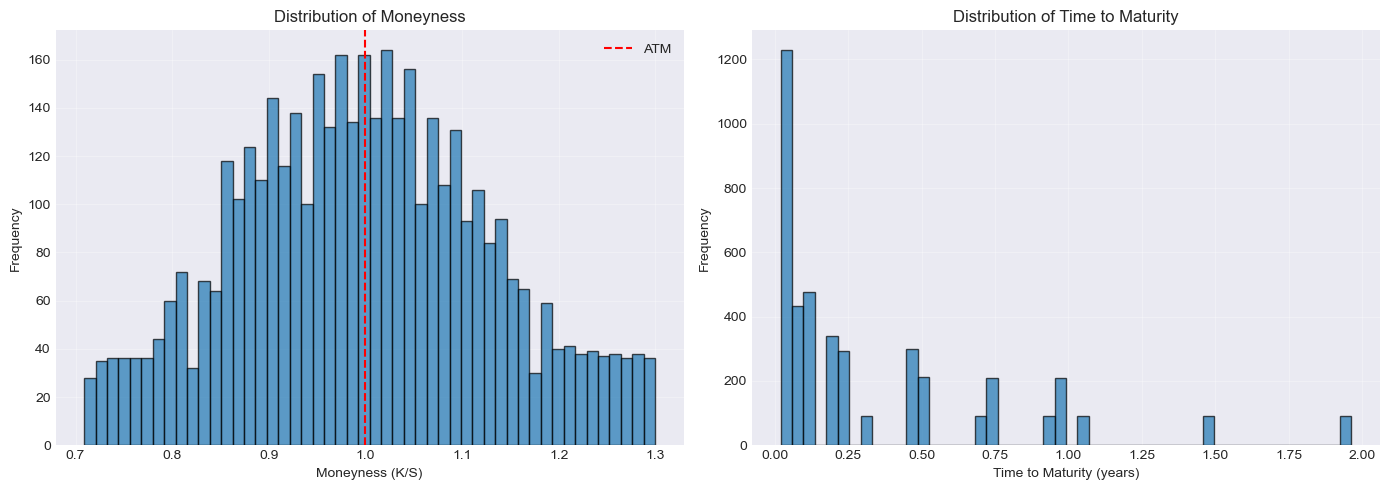

In [11]:
# Plot moneyness distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(iv_df['moneyness'], bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(1.0, color='red', linestyle='--', label='ATM')
axes[0].set_xlabel('Moneyness (K/S)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Moneyness')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(iv_df['T'], bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Time to Maturity (years)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Time to Maturity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

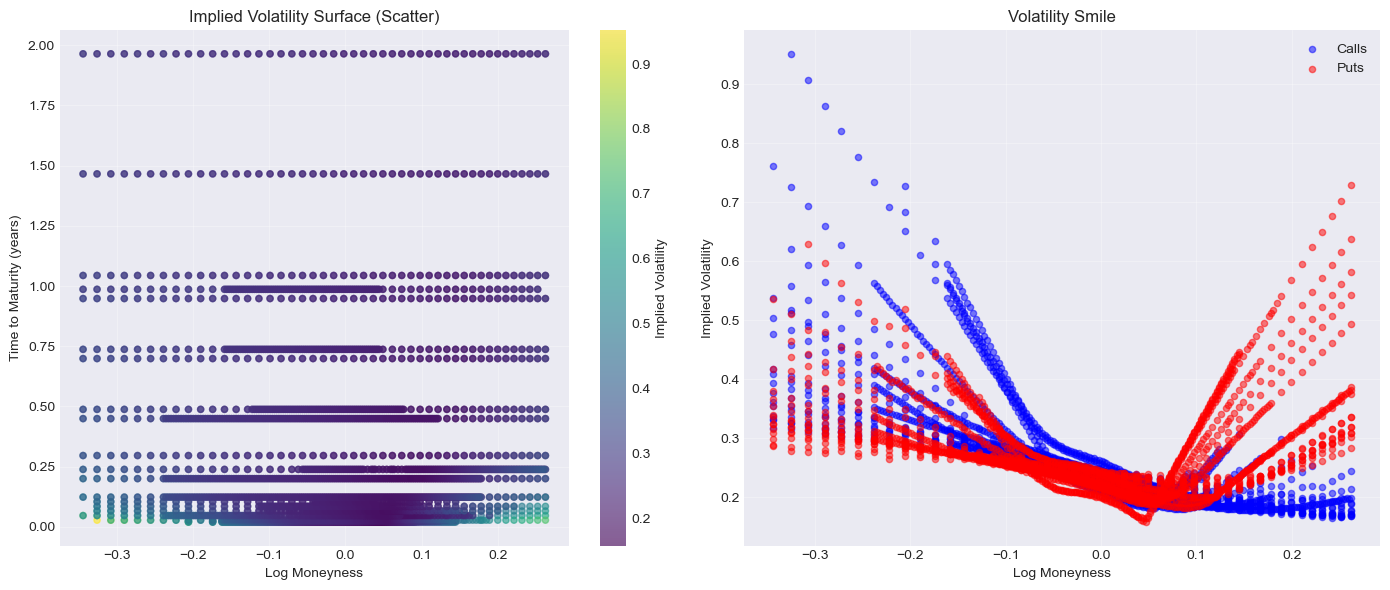

In [12]:
# Plot implied volatility surface
fig = plt.figure(figsize=(14, 6))

# Scatter plot
ax1 = fig.add_subplot(121)
scatter = ax1.scatter(
    iv_df['log_moneyness'], 
    iv_df['T'], 
    c=iv_df['computed_iv'], 
    cmap='viridis', 
    s=20, 
    alpha=0.6
)
ax1.set_xlabel('Log Moneyness')
ax1.set_ylabel('Time to Maturity (years)')
ax1.set_title('Implied Volatility Surface (Scatter)')
plt.colorbar(scatter, ax=ax1, label='Implied Volatility')
ax1.grid(True, alpha=0.3)

# Separate by option type
ax2 = fig.add_subplot(122)
calls = iv_df[iv_df['cp_flag'] == 'C']
puts = iv_df[iv_df['cp_flag'] == 'P']

ax2.scatter(
    calls['log_moneyness'], 
    calls['computed_iv'], 
    c='blue', 
    s=20, 
    alpha=0.5, 
    label='Calls'
)
ax2.scatter(
    puts['log_moneyness'], 
    puts['computed_iv'], 
    c='red', 
    s=20, 
    alpha=0.5, 
    label='Puts'
)
ax2.set_xlabel('Log Moneyness')
ax2.set_ylabel('Implied Volatility')
ax2.set_title('Volatility Smile')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

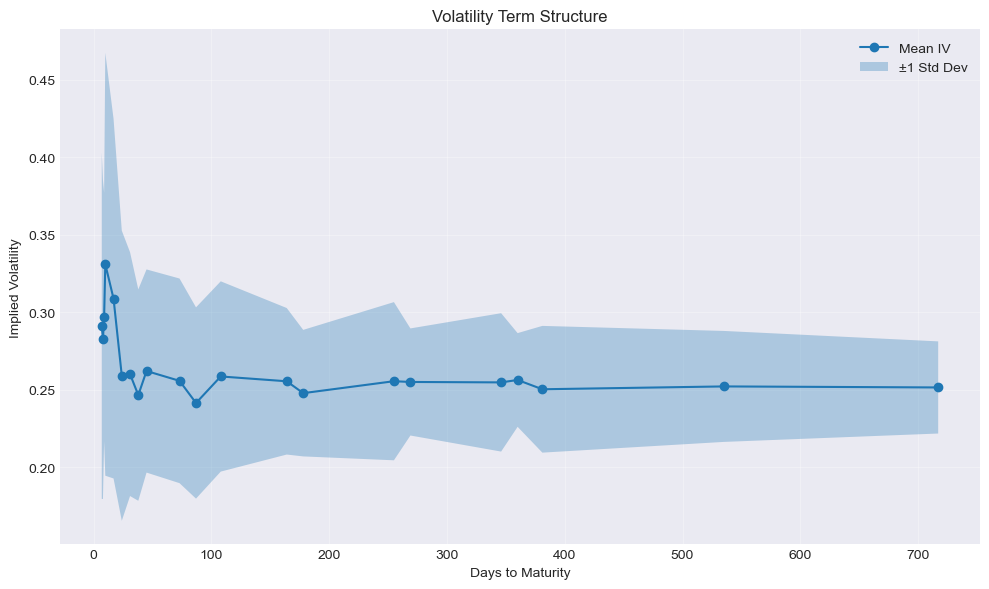

In [13]:
# Plot volatility term structure
fig, ax = plt.subplots(figsize=(10, 6))

# Group by maturity and compute average IV
maturity_groups = iv_df.groupby('days_to_maturity')['computed_iv'].agg(['mean', 'std', 'count'])
maturity_groups = maturity_groups[maturity_groups['count'] >= 5]  # Filter groups with at least 5 observations

ax.plot(maturity_groups.index, maturity_groups['mean'], 'o-', label='Mean IV')
ax.fill_between(
    maturity_groups.index, 
    maturity_groups['mean'] - maturity_groups['std'], 
    maturity_groups['mean'] + maturity_groups['std'], 
    alpha=0.3,
    label='±1 Std Dev'
)

ax.set_xlabel('Days to Maturity')
ax.set_ylabel('Implied Volatility')
ax.set_title('Volatility Term Structure')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Split and Normalize Data

In [14]:
# Split into train and test sets
train_df, test_df = split_data(iv_df, train_ratio=0.8, random_state=42)
print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 3402 samples
Test set: 851 samples


In [15]:
# Create model datasets
input_features = ['log_moneyness', 'T']
target = 'computed_iv'

X_train, y_train, norm_params = create_model_dataset(
    train_df, 
    input_features=input_features, 
    target=target, 
    normalize=True
)

X_test, y_test, _ = create_model_dataset(
    test_df, 
    input_features=input_features, 
    target=target, 
    normalize=False
)

# Apply same normalization to test set
from preprocessing import normalize_features
test_df_normalized, _ = normalize_features(test_df, input_features, method='standard')
# Use training normalization parameters
for feature in input_features:
    mean = norm_params[feature]['mean']
    std = norm_params[feature]['std']
    test_df_normalized[feature] = (test_df[feature] - mean) / std
X_test = test_df_normalized[input_features].values

print(f"\nTraining set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
print(f"\nNormalization parameters: {norm_params}")


Training set shape: X=(3402, 2), y=(3402,)
Test set shape: X=(851, 2), y=(851,)

Normalization parameters: {'log_moneyness': {'mean': -0.010143445142397834, 'std': 0.13235743632334454, 'method': 'standard'}, 'T': {'mean': 0.3381532217148656, 'std': 0.4233318044568121, 'method': 'standard'}}


## 9. Save Processed Data

In [16]:
# Save processed data
processed_path = "../data/processed/"
os.makedirs(processed_path, exist_ok=True)

# Save dataframes
train_df.to_parquet(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_train.parquet"))
test_df.to_parquet(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_test.parquet"))

# Save numpy arrays
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_X_train.npy"), X_train)
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_y_train.npy"), y_train)
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_X_test.npy"), X_test)
np.save(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_y_test.npy"), y_test)

# Save normalization parameters
import json
with open(os.path.join(processed_path, f"{ticker_name}_{date.replace('-', '')}_norm_params.json"), 'w') as f:
    json.dump(norm_params, f, indent=4)

print("Processed data saved successfully!")

Processed data saved successfully!


## Summary

Data preparation completed:
1. Loaded raw option data from WRDS OptionMetrics
2. Extracted spot price and market parameters
3. Cleaned invalid data points
4. Computed implied volatilities using Black-Scholes formula
5. Visualized data distribution and volatility surface
6. Split into training and test sets
7. Normalized features for model input
8. Saved processed data for model training